### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [2]:
#Import
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats
import time
import corner
import numdifftools as nd

In [3]:
#Part 1 

#Load data
data= np.load('../../../homeworks/hw_data/hw3_data_1.npy')

#Organize data
meas=data[:, 0]
uncert= data[:, 1]
#Calculate Mean and Standard Error
mean1= np.sum(meas/(uncert**2))/np.sum(1/uncert**2)
error1= np.sum(1/uncert**2)**(-1/2)
print("Mean:", mean1)
print("Standard Error:", error1)

Mean: 4.082099776157917
Standard Error: 0.0937975025520293


In [4]:
#Part 2 Log-Likelihood
def inverse_log_likelihood(mu, x, x_uncert):
    constant= -1/2 * np.log(2*np.pi*uncert**2)
    return -np.sum( constant - ((x-mu)**2)/(2*(x_uncert)**2)) #use inverse (multiply by -1) because we are using optimize to minimize even though we want to maximize

def find_mean(beta, meas, uncert):
    f_squared = lambda beta: inverse_log_likelihood(beta, meas, uncert) 
    beta_squared = optimize.fmin(f_squared, beta, disp=False)
    return beta_squared

beta=3 #intial guess for mu
mean= find_mean(beta, meas, uncert)
print(mean)

[4.08208008]


In [5]:
#Part 3
#Fisher uncertainty estimate on the mean
f_squared = lambda beta: inverse_log_likelihood(beta, meas, uncert) #have to define the lambda function since it was defined in a function previously
H=nd.Hessian(f_squared)(mean)
fisher_sigma= (H[0][0])**(-1/2)
print("Fisher Uncertainty:", fisher_sigma)

Fisher Uncertainty: 0.0937975025520293


In [6]:
#Part 4
global_start=time.time()
def random_sample(meas, uncert): #This unction will randomly sample from the data and make a new dataset
    rand_indices= np.random.randint(0,len(meas), size=len(meas)) #Use random.randit to get random indicies 
    x=[]
    x_uncert=[]
    for i in rand_indices:
        x.append(float(meas[i])) #match indicies between the measurment data and undertainty by using the same indicies
        x_uncert.append(uncert[i])
    return x, x_uncert

start=time.time()

N=2000

big_x=[]
big_uncert=[]
for i in range(N):
    x, x_uncert= random_sample(meas, uncert)
    big_x.append(x)
    big_uncert.append(x_uncert)
big_x=np.array(big_x)
big_uncert=np.array(big_uncert)
end=time.time()

print("Bootstrap Duration:", end-start, "seconds")



Bootstrap Duration: 0.05929684638977051 seconds


Time to find mean for each reality: 0.945195198059082 seconds


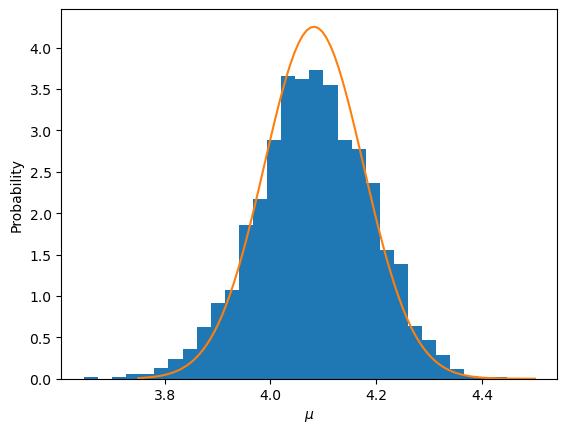

In [7]:
#Part 5
start=time.time()
N=2000
mean_arr=[]
for i in range(N):
    beta=3
    mean= find_mean(beta, big_x[i], big_uncert[i])
    mean_arr.append(mean[0])
end=time.time()
print("Time to find mean for each reality:", end-start, "seconds" )
plt.hist(mean_arr, bins=30, density=True);
plt.xlabel(r'$\mu$')
plt.ylabel('Probability')

#Plot PDF
xgrid= np.linspace(3.75, 4.5, 100)
distG=scipy.stats.norm(mean1, error1)
pdf=distG.pdf(xgrid)
plt.plot(xgrid, pdf)



In [8]:
#Part 6
def inverse_ln_laplace(loc, scale, meas):
    N= len(meas)
    return -(N*(-np.log(2*scale)) - np.sum(np.abs(meas-loc)/scale))
f_laplace = lambda beta: inverse_ln_laplace(beta[0], beta[1] , meas)
beta=(3,1)
beta_squared = optimize.fmin(f_laplace, beta, disp=False)
print(r"$\mu$=", beta_squared[0],  r"$ \Delta $=", beta_squared[1])

$\mu$= 4.089887652271702 $ \Delta $= 0.9260493721621862


In [9]:
#Part 7 AIC
mean= find_mean(3, meas, uncert)
L_hetero=-1* inverse_log_likelihood(mean, meas, uncert)
L_laplace= -1 * inverse_ln_laplace(beta_squared[0], beta_squared[1], meas)

def AIC(L, k, N):
    aic= -2*L + 2*k + (2*k*(k+1))/(N-k-1)
    return aic 

AIC_hetero= AIC(L_hetero, 1, len(meas))
AIC_laplace= AIC(L_laplace, 2, len(meas))

print(f"AIC for Gaussian= {AIC_hetero}, AIC for Laplace= {AIC_laplace}")
print("Gaussian is most favored")

AIC for Gaussian= 309.27790935326897, AIC for Laplace= 327.38759523958527
Gaussian is most favored


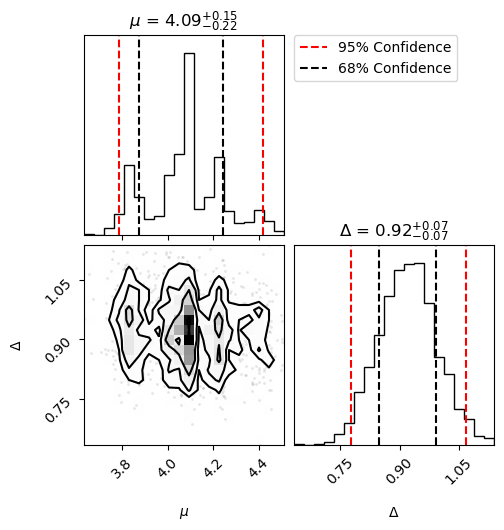

In [10]:
#Part 8 
def find_mean_laplace(beta, meas): #finds the mean for the laplacian
    f_squared = lambda beta: inverse_ln_laplace(beta[0], beta[1], meas)
    beta_squared = optimize.fmin(f_squared, beta, disp=False)
    return beta_squared

#Iterate through all 2000 realities in the bootstrap
N=2000
loc_arr=[]
scale_arr=[]
for i in range(N):
    beta=(3,1)
    beta_squared= find_mean_laplace(beta, big_x[i])
    loc_arr.append(float(beta_squared[0]))
    scale_arr.append(float(beta_squared[1]))

loc_arr= np.array(loc_arr)
scale_arr=np.array(scale_arr)

laplace_data=np.vstack((loc_arr, scale_arr)).T

#Corner Plot
fig = corner.corner(
    laplace_data,
    labels=[r"$\mu$", r"$\Delta$"],  
    show_titles=True,
    title_kwargs={"fontsize": 12},  
    hist_kwargs={"density": True},  # Ensure histograms are normalized
    plot_density=True,
)

#I tried to use the 'quantiles' argument in corner.corner but I was only able to plot 3 quantiles
# To show both 68% and 98% confidence intervals, I had some help from ChatGPT to implement 2 sets of vlines for each confidence interval
axes = np.array(fig.axes).reshape((2, 2))  # Assuming 2D data

for i in range(2): 
    ax = axes[i, i]
    q_68 = np.percentile(laplace_data[:, i], [16, 84])  # 68% CI
    q_95 = np.percentile(laplace_data[:, i], [2.5, 97.5])  # Compute 95% 
    # Plot 95% CI in red dashed lines
    for j, q in enumerate(q_95):
        ax.axvline(q, color="red", linestyle="dashed", label="95% Confidence" if j == 0 else "")
    
    # Plot 68% CI in blue solid lines
    for j, q in enumerate(q_68):
        ax.axvline(q, color="black", linestyle="dashed", label="68% Confidence" if j == 0 else "")


# Show legend in the tope left plot and move the legend outside of the plot (to the right)
axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Adjust the plot layout to prevent clipping
#plt.tight_layout()

plt.show()


In [11]:
#Part 9
H=nd.Hessian(f_laplace)(beta_squared) #Returns a matrix with values corresponding to beta_squared along the diagonals
fisher_loc= (H[0][0])**(-1/2) 
fisher_scale=(H[1][1])**(-1/2)
print(f"Fisher Uncertainty for Loc= {fisher_sigma}, Fisher Uncertainty for Scale={fisher_scale}")

Fisher Uncertainty for Loc= 0.0937975025520293, Fisher Uncertainty for Scale=0.06699094576663105
